In [ ]:
!pip install tensorflow numpy scikit-learn umap-learn matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/My Drive/Project 425/final_data_features.csv'  # Update path if needed
data = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import umap

In [ ]:
# Check the column names of the dataset
data.columns

Index(['id', 'genre', 'audio_path', 'lyric_path', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'tfidf_ai', 'tfidf_away', 'tfidf_ce',
       'tfidf_che', 'tfidf_come', 'tfidf_dans', 'tfidf_des', 'tfidf_di',
       'tfidf_don', 'tfidf_du', 'tfidf_el', 'tfidf_en', 'tfidf_es',
       'tfidf_est', 'tfidf_et', 'tfidf_feel', 'tfidf_got', 'tfidf_il',
       'tfidf_je', 'tfidf_just', 'tfidf_know', 'tfidf_la', 'tfidf_le',
       'tfidf_les', 'tfidf_let', 'tfidf_life', 'tfidf_like', 'tfidf_ll',
       'tfidf_love', 'tfidf_ma', 'tfidf_make', 'tfidf_mi', 'tfidf_ne',
       'tfidf_non', 'tfidf_oh', 'tfidf_pas', 'tfidf_pour', 'tfidf_qu',
       'tfidf_que', 'tfidf_qui', 'tfidf_se', 'tfidf_si', 'tfidf_te',
       'tfidf_time', 'tfidf_tu', 'tfidf_une', 'tfidf_ve', 'tfidf_want',
       'tfidf_yeah', 'tfidf_ça'],
      dtype='object')

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

def build_encoder_conv(input_shape, latent_dim=8):
    encoder_inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


In [ ]:
def build_decoder_conv(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Reshape((64, 4))(x)

    x = layers.Conv1DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv1DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv1DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

    decoder_outputs = layers.Conv1DTranspose(output_shape[1], 3, activation='sigmoid', padding='same')(x)

    return models.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
from tensorflow.keras.layers import Concatenate

def build_encoder_hybrid(input_shape_audio, input_shape_lyrics, latent_dim=8):
    # Audio input
    audio_input = layers.Input(shape=input_shape_audio)
    x_audio = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(audio_input)
    x_audio = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x_audio)
    x_audio = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x_audio)
    x_audio = layers.Flatten()(x_audio)

    # Lyrics input (TF-IDF)
    lyrics_input = layers.Input(shape=input_shape_lyrics)
    x_lyrics = layers.Dense(128, activation='relu')(lyrics_input)
    x_lyrics = layers.Dense(64, activation='relu')(x_lyrics)

    # Combine audio and lyrics
    combined = Concatenate()([x_audio, x_lyrics])

    # Latent space
    z_mean = layers.Dense(latent_dim, name="z_mean")(combined)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(combined)

    # Sampling layer (reparameterization trick)
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return models.Model([audio_input, lyrics_input], [z_mean, z_log_var, z], name="encoder")


In [ ]:
def build_decoder_hybrid(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Reshape((64, 4))(x)  # Reshaping for Conv1DTranspose layers

    x = layers.Conv1DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv1DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv1DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

    decoder_outputs = layers.Conv1DTranspose(output_shape[1], 3, activation='sigmoid', padding='same')(x)

    return models.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        audio_input, lyrics_input = data  # unpack the inputs

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input], training=True)
            reconstruction = self.decoder(z, training=True)

            # MSE reconstruction loss
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(audio_input - reconstruction), axis=1))

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))

            # Total loss
            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Track metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        audio_input, lyrics_input = inputs
        z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input])
        reconstruction = self.decoder(z)
        return reconstruction


In [ ]:
import numpy as np

# Pad the audio data to make the total number of elements divisible by (time_steps * num_features)
desired_length = 100 * 13  # For example, 100 time steps and 13 features
remainder = X_audio.shape[0] % desired_length

# Pad with zeros (or another value if needed)
if remainder > 0:
    pad_size = desired_length - remainder
    X_audio_padded = np.pad(X_audio, ((0, pad_size), (0, 0)), mode='constant')
else:
    X_audio_padded = X_audio

# Reshape the padded data into (samples, time_steps, num_features)
X_audio_reshaped = X_audio_padded.reshape(-1, 100, 13)

print("X_audio shape after reshaping:", X_audio_reshaped.shape)


X_audio shape after reshaping: (65, 100, 13)


In [ ]:
# If X_lyrics has more samples, truncate it to match X_audio_reshaped
X_lyrics_aligned = X_lyrics[:X_audio_reshaped.shape[0]]


In [ ]:
import numpy as np

# Re-apply padding and reshaping to ensure X_audio_reshaped is 3D
# This step is included here to ensure robustness against potential state inconsistencies
# from previous cell executions where X_audio_reshaped might have been modified or not properly set.

desired_length = 100 * 13  # 100 time steps and 13 features
remainder = X_audio.shape[0] % desired_length

if remainder > 0:
    pad_size = desired_length - remainder
    X_audio_padded = np.pad(X_audio, ((0, pad_size), (0, 0)), mode='constant')
else:
    X_audio_padded = X_audio

X_audio_reshaped = X_audio_padded.reshape(-1, 100, 13)

# Ensure X_lyrics_aligned matches the number of samples in X_audio_reshaped
X_lyrics_aligned = X_lyrics[:X_audio_reshaped.shape[0]]

input_shape_audio = X_audio_reshaped.shape[1:]
input_shape_lyrics = X_lyrics_aligned.shape[1:]
# Set the latent dimension to 4 (or another value based on your experiments)
latent_dim = 4

# Build the hybrid encoder with latent_dim
encoder_hybrid = build_encoder_hybrid(input_shape_audio, input_shape_lyrics, latent_dim=latent_dim)

# Build the hybrid decoder with the same latent_dim
decoder_hybrid = build_decoder_hybrid(latent_dim, input_shape_audio)


In [ ]:
# Instantiate the VAE model for hybrid features
vae_hybrid = VAE(encoder_hybrid, decoder_hybrid, beta=1.0)  # Use the correct latent_dim

# Compile the VAE model
vae_hybrid.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

In [ ]:
# Instantiate the VAE model for hybrid features
vae_hybrid = VAE(encoder_hybrid, decoder_hybrid, beta=1.0)  # Use the correct latent_dim

# Compile the VAE model
vae_hybrid.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

In [ ]:
# Train the VAE with hybrid features (X_audio: reshaped MFCC features, X_lyrics: TF-IDF features)
vae_hybrid.fit([X_audio_reshaped, X_lyrics_aligned], epochs=50, batch_size=64)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - kl_loss: 435212.2188 - loss: 770520.3125 - reconstruction_loss: 335308.0625
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - kl_loss: 300.3587 - loss: 311774.6562 - reconstruction_loss: 311474.3125
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: 167.5335 - loss: 336178.8438 - reconstruction_loss: 336011.3125
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - kl_loss: 344.9345 - loss: 308483.2500 - reconstruction_loss: 308138.3125
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - kl_loss: 928.0555 - loss: 328246.0312 - reconstruction_loss: 327318.0000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 566.6910 - loss: 332354.7188 - reconstruction_loss: 331788.0625
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - kl_loss: 287.2284 - loss: 317561.1875 - reconstruction_loss: 317273.9688 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - kl_loss: 449.6327 - loss: 346112.0938 - reconstruction_loss: 345662.4375 
Ep

In [ ]:
# # Extract latent features from the trained encoder (z_mean)
# z_mean_hybrid, _, _ = vae_hybrid.encoder([X_audio_reshaped, X_lyrics_aligned])

# # Convert to numpy array if it's a TensorFlow tensor
# z_mean_hybrid_np = z_mean_hybrid.numpy() if hasattr(z_mean_hybrid, "numpy") else z_mean_hybrid

# # Check for NaNs and handle them before clustering
# if np.isnan(z_mean_hybrid_np).any():
#     print("NaNs found in z_mean_hybrid. Handling NaNs.")
#     # Option 1: Remove rows with NaNs
#     original_shape = z_mean_hybrid_np.shape[0]
#     z_mean_hybrid_np = z_mean_hybrid_np[~np.isnan(z_mean_hybrid_np).any(axis=1)]
#     print(f"Removed {original_shape - z_mean_hybrid_np.shape[0]} rows containing NaNs.")

#     # Also, ensure that the data DataFrame aligns if rows are removed
#     # For simplicity, if rows are removed from z_mean_hybrid, we should also filter data for clustering if needed.
#     # However, since VAE was trained on X_audio_reshaped (65 samples), this check primarily ensures the output validity.

#     if z_mean_hybrid_np.shape[0] == 0:
#         print("All data removed due to NaNs. Cannot perform clustering.")

# # Proceed with clustering only if data is available
# if z_mean_hybrid_np.shape[0] > 0:
#     # Apply K-Means clustering
#     kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
#     labels_kmeans = kmeans.fit_predict(z_mean_hybrid_np)

#     # Apply Agglomerative Clustering
#     agglo = AgglomerativeClustering(n_clusters=5)
#     labels_agglo = agglo.fit_predict(z_mean_hybrid_np)

#     # Apply DBSCAN clustering
#     # Adjust eps and min_samples if necessary based on data density
#     dbscan = DBSCAN(eps=0.5, min_samples=2) # Reduced min_samples for potentially smaller dataset
#     labels_dbscan = dbscan.fit_predict(z_mean_hybrid_np)

#     # Add cluster labels to the data
#     # IMPORTANT: Ensure 'data' DataFrame is aligned with z_mean_hybrid_np if rows were removed.
#     # For this current scenario, z_mean_hybrid_np would have the same number of rows as X_audio_reshaped and X_lyrics_aligned (65)
#     # if the VAE trained successfully without producing NaNs itself. So, we'll add them to the corresponding subset.
#     temp_data_for_clustering = data.iloc[:z_mean_hybrid_np.shape[0]].copy()
#     temp_data_for_clustering['kmeans_cluster'] = labels_kmeans
#     temp_data_for_clustering['agglo_cluster'] = labels_agglo
#     temp_data_for_clustering['dbscan_cluster'] = labels_dbscan

#     # Update original data DataFrame for the processed subset
#     data.loc[temp_data_for_clustering.index, 'kmeans_cluster'] = temp_data_for_clustering['kmeans_cluster']
#     data.loc[temp_data_for_clustering.index, 'agglo_cluster'] = temp_data_for_clustering['agglo_cluster']
#     data.loc[temp_data_for_clustering.index, 'dbscan_cluster'] = temp_data_for_for_clustering['dbscan_cluster']

#     # Show the results
#     print(data[['id', 'kmeans_cluster', 'agglo_cluster', 'dbscan_cluster']].head())
# else:
#     print("Clustering skipped due to no valid data after NaN handling.")



# Extract latent features (z_mean) from the trained encoder
z_mean_hybrid, _, _ = vae_hybrid.encoder([X_audio_reshaped, X_lyrics_aligned])

# Convert to numpy array if it's a TensorFlow tensor
z_mean_hybrid_np = z_mean_hybrid.numpy() if hasattr(z_mean_hybrid, "numpy") else z_mean_hybrid

# Check for NaNs and handle them before clustering
if np.isnan(z_mean_hybrid_np).any():
    print("NaNs found in z_mean_hybrid. Handling NaNs.")
    # Option 1: Remove rows with NaNs
    original_shape = z_mean_hybrid_np.shape[0]
    z_mean_hybrid_np = z_mean_hybrid_np[~np.isnan(z_mean_hybrid_np).any(axis=1)]
    print(f"Removed {original_shape - z_mean_hybrid_np.shape[0]} rows containing NaNs.")

    if z_mean_hybrid_np.shape[0] == 0:
        print("All data removed due to NaNs. Cannot perform clustering.")


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
labels_kmeans = kmeans.fit_predict(z_mean_hybrid_np)

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5)
labels_agglo = agglo.fit_predict(z_mean_hybrid_np)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples if necessary
labels_dbscan = dbscan.fit_predict(z_mean_hybrid_np)


In [ ]:
# Create a new DataFrame to store the clustering results
# We'll use only the first 65 rows of the original 'data' DataFrame (matching the number of samples used in clustering)
data_for_clustering = data.iloc[:65].copy()

# Add cluster labels to the new DataFrame
data_for_clustering['kmeans_cluster'] = labels_kmeans
data_for_clustering['agglo_cluster'] = labels_agglo
data_for_clustering['dbscan_cluster'] = labels_dbscan

# Update the original 'data' DataFrame with the clustering results (for the first 65 rows)
data.loc[data_for_clustering.index, 'kmeans_cluster'] = data_for_clustering['kmeans_cluster']
data.loc[data_for_clustering.index, 'agglo_cluster'] = data_for_clustering['agglo_cluster']
data.loc[data_for_clustering.index, 'dbscan_cluster'] = data_for_clustering['dbscan_cluster']

# Show the results
print(data[['id', 'kmeans_cluster', 'agglo_cluster', 'dbscan_cluster']].head())

        id  kmeans_cluster  agglo_cluster  dbscan_cluster
0  1001890             0.0            2.0            -1.0
1  1001891             2.0            0.0            -1.0
2  1002753             0.0            2.0            -1.0
3  1003648             4.0            0.0            -1.0
4  1003654             4.0            0.0            -1.0


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


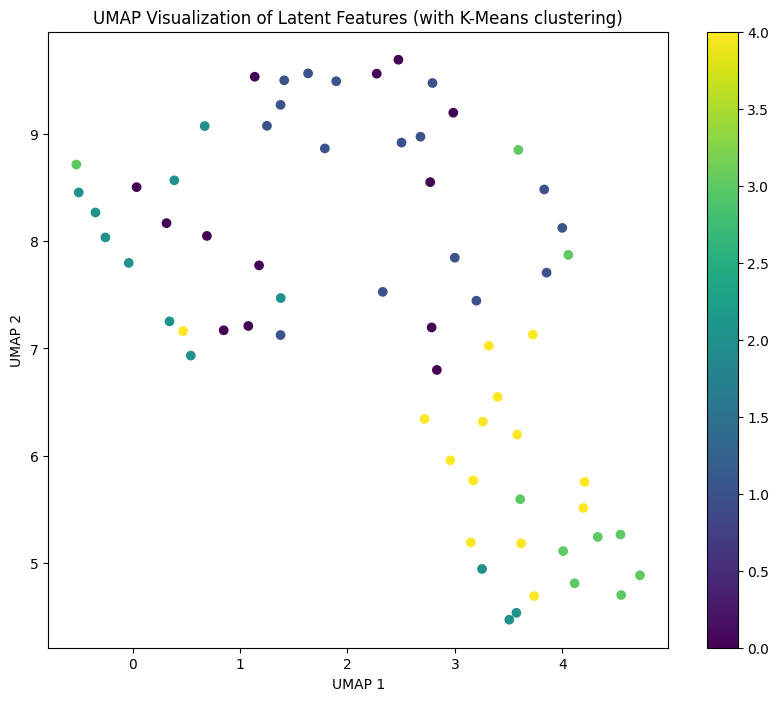

In [ ]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP to reduce the latent features to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation', random_state=42)
latent_features_umap = umap_model.fit_transform(z_mean_hybrid_np)

# Visualize the clusters in UMAP space (using K-Means labels)
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_umap[:, 0], latent_features_umap[:, 1], c=labels_kmeans, cmap='viridis')
plt.colorbar()
plt.title("UMAP Visualization of Latent Features (with K-Means clustering)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

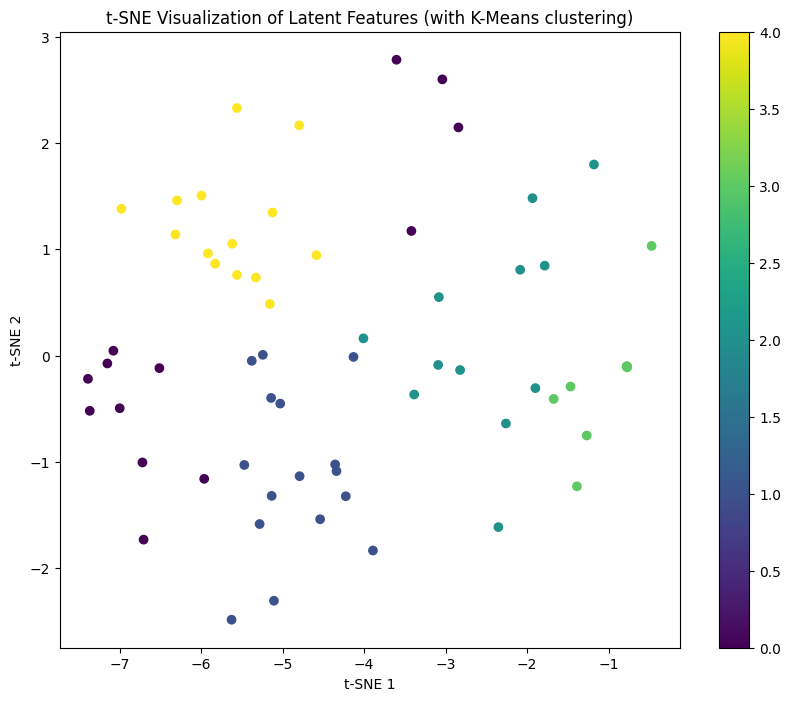

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the latent features to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_features_tsne = tsne.fit_transform(z_mean_hybrid_np)

# Visualize the clusters in t-SNE space (using K-Means labels)
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_tsne[:, 0], latent_features_tsne[:, 1], c=labels_kmeans, cmap='viridis')
plt.colorbar()
plt.title("t-SNE Visualization of Latent Features (with K-Means clustering)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate K-Means clustering
sil_score_kmeans = silhouette_score(z_mean_hybrid_np, labels_kmeans)
db_score_kmeans = davies_bouldin_score(z_mean_hybrid_np, labels_kmeans)

print(f"K-Means Silhouette Score: {sil_score_kmeans}")
print(f"K-Means Davies-Bouldin Score: {db_score_kmeans}")


K-Means Silhouette Score: 0.25073838233947754
K-Means Davies-Bouldin Score: 1.2581752606050387


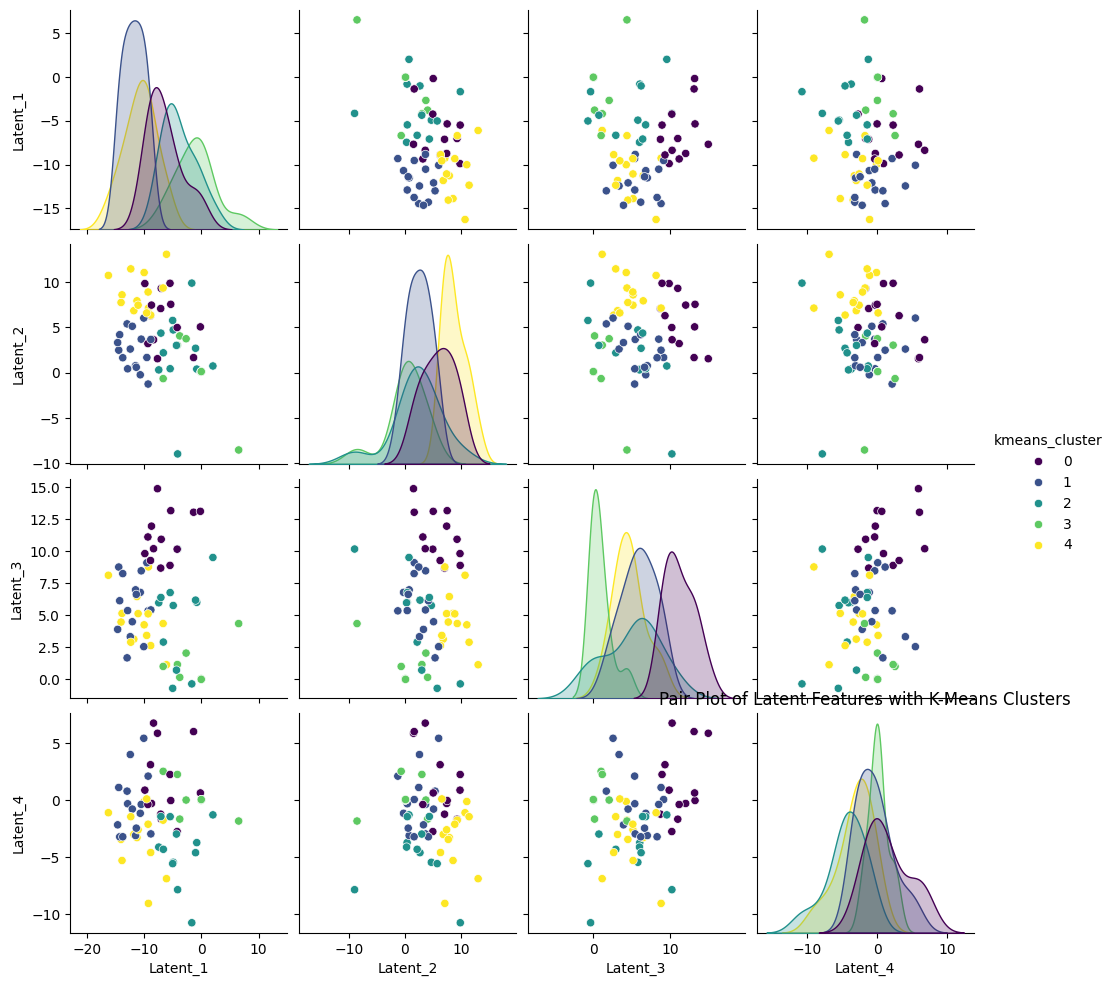

In [ ]:
import seaborn as sns
import pandas as pd

# Convert the latent features and clustering labels to a DataFrame
latent_features_df = pd.DataFrame(z_mean_hybrid_np, columns=[f'Latent_{i+1}' for i in range(z_mean_hybrid_np.shape[1])])
latent_features_df['kmeans_cluster'] = labels_kmeans

# Create a pair plot to visualize the clusters
sns.pairplot(latent_features_df, hue='kmeans_cluster', palette='viridis')
plt.title("Pair Plot of Latent Features with K-Means Clusters")
plt.show()


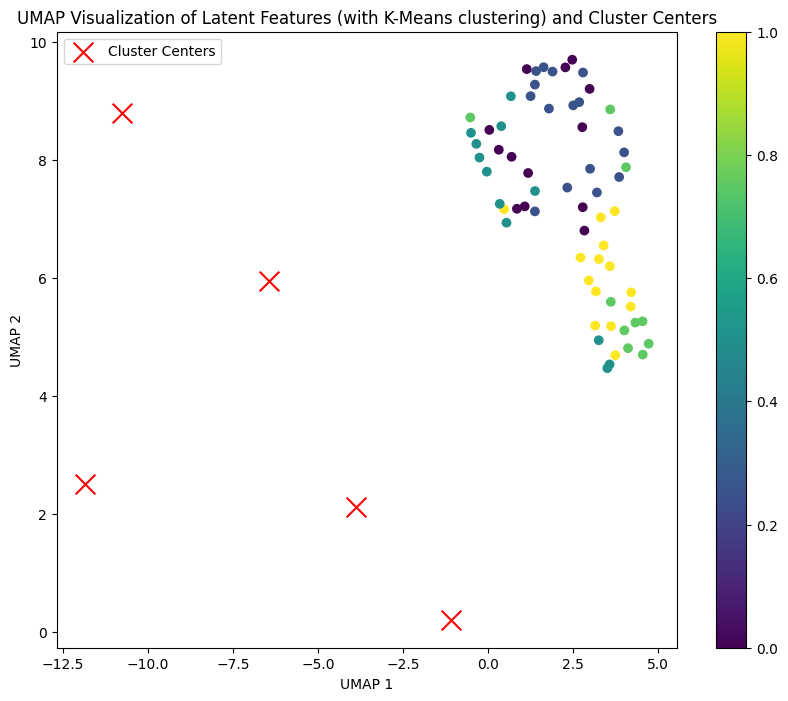

In [ ]:
# Get the cluster centers from K-Means
cluster_centers = kmeans.cluster_centers_

# Plot the UMAP projection again, but this time also plot the cluster centers
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_umap[:, 0], latent_features_umap[:, 1], c=labels_kmeans, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', s=200, label="Cluster Centers")
plt.colorbar()
plt.title("UMAP Visualization of Latent Features (with K-Means clustering) and Cluster Centers")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


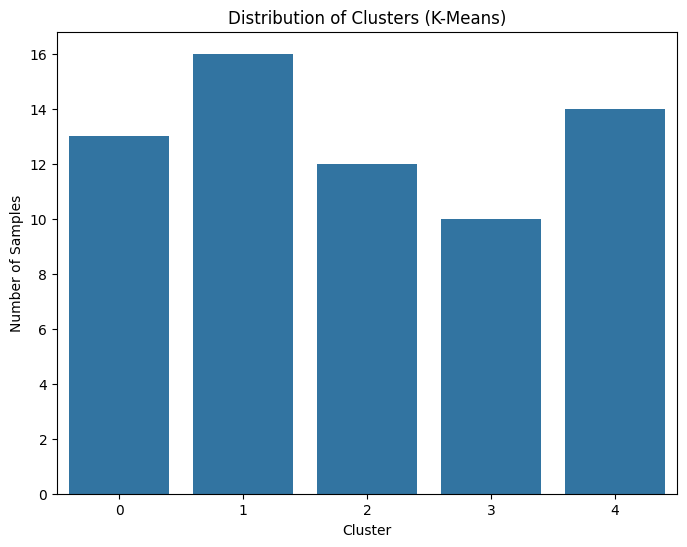

In [ ]:
# Visualize the distribution of clusters (K-Means)
plt.figure(figsize=(8, 6))
sns.countplot(x=labels_kmeans)
plt.title("Distribution of Clusters (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.show()


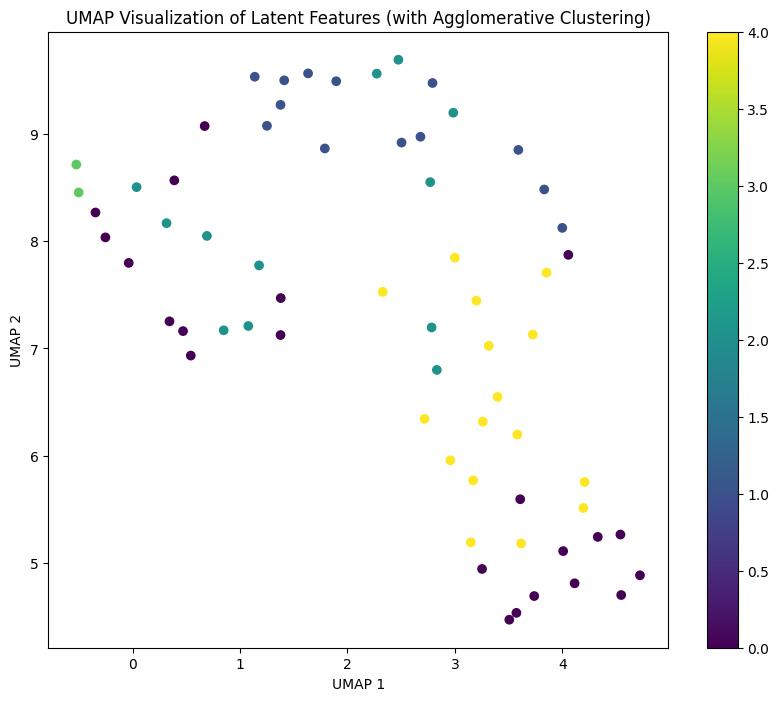

In [ ]:
# Visualize Agglomerative Clustering in UMAP space
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_umap[:, 0], latent_features_umap[:, 1], c=labels_agglo, cmap='viridis')
plt.colorbar()
plt.title("UMAP Visualization of Latent Features (with Agglomerative Clustering)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


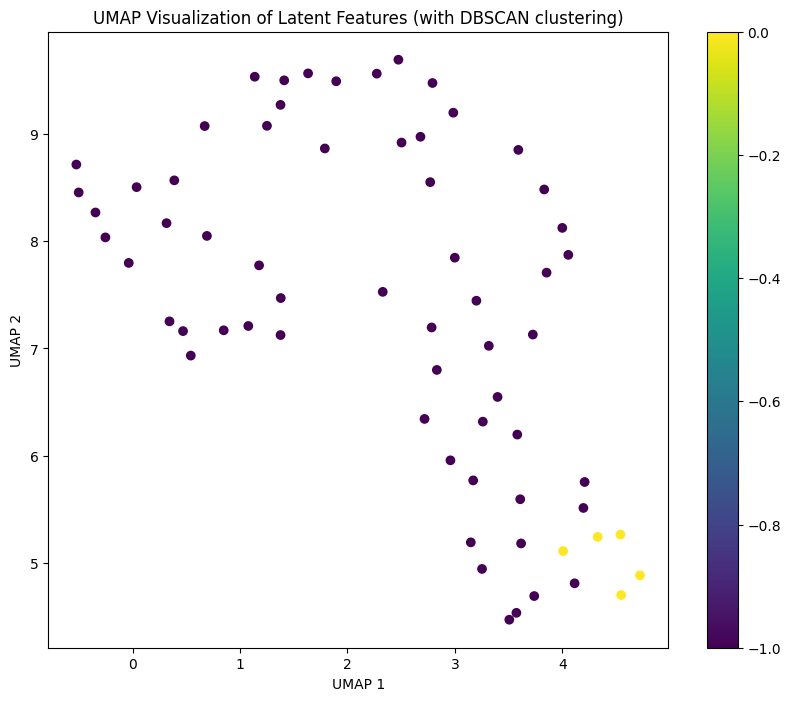

In [ ]:
# Visualize DBSCAN clustering in UMAP space
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_umap[:, 0], latent_features_umap[:, 1], c=labels_dbscan, cmap='viridis')
plt.colorbar()
plt.title("UMAP Visualization of Latent Features (with DBSCAN clustering)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [ ]:
# Save the data with the clustering results
data.to_csv("/content/drive/My Drive/Project 425/clustered_data_with_hybrid_features.csv", index=False)
print("Clustering results with hybrid features saved.")

Clustering results with hybrid features saved.
